# Importing packages

In [ ]:

import tensorflow as tf

import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from  tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling1D


import numpy as np
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

# Instructions

In [10]:
"""The goal of this lab is to classify Wikipedia abstracts about people by their professions. For example, the professions of Elvis Presley are "singer" and "actor".

=== Input ===

The input for training is a file wiki-train.json, which contains Wikipedia abstracts in the following form:
   {"title": "George_Washington",
    "summary": "George Washington was one of the ..."
    "occupations": ["yago:politician"]}

The input for testing is a file wiki-test.json, which contains Wikipedia abstracts of the same shape without the occupations:

   {"title": "Douglas_Adams",
    "summary": "Douglas Noel Adams was ..."}

=== Output ===

The output shall be a JSON file that assigns each Wikipedia abstract to a set of occupations:
   {"title": "Douglas_Adams",
    "occupations": ["Q36180", "Q28389"]}

We provide a gold standard of this form for the development input file.

=== Datasets ===

We provide 3 datasets:
1) a training dataset, which has the labels
2) a development dataset, which has the labels
3) a testing dataset, which does not have the labels, and which we use for grading

=== What to do ===

Adapt the method create_model(), so that it creates a neural network model that classifies the sentence.
There is no need to modify the other parts of the code -- although you are allowed to do so.

=== Suggestions ===
1) Select a suitable theta value
Reference: held-out set, cross validation, grid search...

2) Use pre-trained embeddings
reference: word2vector, GloVe, FastText...

3) Add extra features
reference: stop words, part-of-speech...

4) Try other neural networks
reference: CNN, RNN, Attention, Transformer

5) Avoid overfitting
reference: regularization, dropout...

6) Adjust other parameters
reference: learning rate, batch_size, epoch, layer's dimension

==== Submission ===

1) Take your code, any necessary resources to run the code, and the output of your code on the test dataset (no need to put the other datasets!)
2) ZIP these files in a file called firstName_lastName.zip
3) submit it here before the deadline announced during the lab:

https://www.dropbox.com/request/zwBcRYj17giDjCyPqFQM

"""

'The goal of this lab is to classify Wikipedia abstracts about people by their professions. For example, the professions of Elvis Presley are "singer" and "actor".\n\n=== Input ===\n\nThe input for training is a file wiki-train.json, which contains Wikipedia abstracts in the following form:\n   {"title": "George_Washington",\n    "summary": "George Washington was one of the ..."\n    "occupations": ["yago:politician"]}\n\nThe input for testing is a file wiki-test.json, which contains Wikipedia abstracts of the same shape without the occupations:\n\n   {"title": "Douglas_Adams",\n    "summary": "Douglas Noel Adams was ..."}\n\n=== Output ===\n\nThe output shall be a JSON file that assigns each Wikipedia abstract to a set of occupations:\n   {"title": "Douglas_Adams",\n    "occupations": ["Q36180", "Q28389"]}\n\nWe provide a gold standard of this form for the development input file.\n\n=== Datasets ===\n\nWe provide 3 datasets:\n1) a training dataset, which has the labels\n2) a developme

# Original Code

In [6]:
# Install necessary modules
import sys
import subprocess
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

file1 = open('requirements.txt', 'r')
requirements = file1.readlines()
for req in requirements:
    reqs = subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', req.strip("\n"), '--quiet'])

In [7]:
"""
This cell imports modules necessary to run this lab.
"""
import gzip
import json
import nltk
from tqdm import tqdm
import numpy as np
from keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
"""
This cell provides some basic function to extracting occupations.
There is no need to modify this file unless you want.
"""

class InputSample(object):
    def __init__(self, title, summary, occupation):
        self.title = title
        self.summary = summary
        self.occupation = occupation


def pad_sentence(sentence, max_len):
    '''
    make all sentences have the same length
    :param sentence:
    :param max_len:
    :return:
    '''
    seg_id = pad_sequences([sentence], maxlen=max_len, padding='post')
    return seg_id[0]


def get_label():
    occupations = [
        'yago:Politician',
        'yago:Researcher',
        'yago:Football_player',
        'yago:Writer',
        'yago:Actor',
        'yago:Painter',
        'yago:Journalist',
        'yago:University_teacher',
        'yago:Singer',
        'yago:Poet',
        'yago:Composer',
        'yago:Military_personnel',
        'yago:Lawyer',
        'yago:Film_actor',
        'yago:Businessperson',
        'yago:Historian',
        'yago:Musician',
        'yago:Film_director',
        'yago:Screenwriter',
        'yago:Physician'
    ]

    labels = {occ_id: index for index, occ_id in enumerate(occupations)}
    id_to_labels = {index: occ_id for index, occ_id in enumerate(occupations)}
    return labels, id_to_labels


def load_data(filename):
    '''
    load original data
    :param filename:
    :return:
    '''
    with gzip.open(filename, 'rt') as fp:
        for line in fp:
            people = json.loads(line)
            occ_key = 'occupations'
            occupations = people[occ_key] if occ_key in people else None
            sample = InputSample(people['title'], people['summary'], occupations)
            yield sample


def gen_vocabulary(data_file, vocab_file):
    '''
    generate a word list given an input corpus
    :param data_file:
    :param vocab_file:
    :return:
    '''
    vocab = set()
    for sample in tqdm(load_data(data_file)):
        sentence = str.lower(sample.summary)
        tokens = nltk.word_tokenize(sentence)
        vocab.update(set(tokens))

    with open(vocab_file, 'w', encoding='utf8')as f:
        f.write('\n'.join(list(vocab)))

    print('done! The size of vocabulary is {a}.'.format(a=len(vocab)))


def load_vocabulary(vocab_file):
    '''
    load vocabulary and create an id for each token.
    <pad> means padding token, <unk> means unknown token
    :param vocab_file:
    :return:
    '''
    vocab_to_id = dict()
    with open(vocab_file, encoding='utf8')as f:
        words = f.readlines()
        for w_id, word in enumerate(words):
            word = word.replace('\n', '')
            vocab_to_id[word] = w_id+1
    vocab_to_id['<pad>'] = 0
    vocab_to_id['<unk>'] = len(vocab_to_id)
    return vocab_to_id


def read_dataset(data_file, vocab_to_id, sent_len, debug=False):
    '''
    read training set or test set
    :param data_file:
    :param vocab_to_id:
    :param sent_len: the
    :param debug: load only a small fraction of samples to debug
    :return: model's input and labels
    need about 1min31s for training set and 2min for test set
    '''

    labels, _ = get_label()
    unknown_id = len(vocab_to_id) - 1
    data_x, data_y = list(), list()
    cnt = 0
    
    for sample in tqdm(load_data(data_file)):
        # print(sample)

        # for debugging
        cnt += 1
        if debug and cnt > 100:
            break

        summary = str.lower(sample.summary)
        tokens = nltk.word_tokenize(summary)
        token_ids = [vocab_to_id.get(t, unknown_id) for t in tokens]
        token_ids = pad_sentence(token_ids, sent_len)
        data_x.append(token_ids)
        occupations = sample.occupation

        # train
        if occupations:
            y_vector = [1 if label in occupations else 0 for label in labels]
            data_y.append(y_vector)
        # test
        else:
            data_y.append(0)

    return np.array(data_x), np.array(data_y)


def f1_score(true_labels, pred_labels):
    """Compute the F1 score."""
    nb_correct, nb_pred, nb_true = 0, 0, 0
    for true, pred in zip(true_labels, pred_labels):
        nb_correct += len(true & pred)
        nb_pred += len(pred)
        nb_true += len(true)

    p = nb_correct / nb_pred if nb_pred > 0 else 0
    r = nb_correct / nb_true if nb_true > 0 else 0
    score = 2 * p * r / (p + r) if p + r > 0 else 0

    return score, p, r



In [11]:
# input files
# [ train_file ] is a training dataset that contains 266K samples.
# [ test_file ] is a testing dataset that contains 200K samples. You can test your model based on this file.
# [ predict_file ] is a predicting dataset that contains 201K samples. Each sample in this file does not have occupation labels.

train_file = 'wiki-train.json.gz'
test_file = 'wiki-dev.json.gz'
predict_file = 'wiki-test.json.gz'

# output files
# [ vocab_file ] has a word vocabulary that defines which words participate in this task.
# The default vocabulary is generated by our methods from training dataset,
# but you can create it in a way you like.
# [ model_file ] is used for store your trained model
# [ result_file ] is file that stores your predicted occupations.
# (This is the file you have to submit, once you ran on the test dataset)

vocab_file = 'vocab.txt'


In [ ]:
model_file = 'model_Saad_Lahlali.h5'
result_file = 'result_Saad_Lahlali.json'

embedding_dimension = 300
maximal_sentence_length = 100
number_of_labels = 20
epochs = 8
batch_size = 32

# Pre-trained Glove

## Downloading the pretrained Glove

In [ ]:
'''
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
data_path = tf.keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)
'''

## Embedding 

In [ ]:
path_to_glove_file = "./glove.6B."+str(embedding_dimension)+"d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
vocab_to_id = load_vocabulary(vocab_file)
num_tokens = len(vocab_to_id)
word_index = dict(zip(vocab_to_id, range(len(vocab_to_id))))
embedding_dim = embedding_dimension
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 164797 words (179382 misses)


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# Text Classification

## Preparing the Network

In [12]:
# Number of units in each network
LAYERS = [ 164, 164, 128, 128, 64, 64, 32, 32]
LAYERS1 = [ 164, 128, 64, 32]

In [13]:
def create_model_2(vocab):
    '''
    :param vocab: a vocabulary dictionary which looks like {'python':0, 'java':1 ......}
    :return:
    '''
    # First Input Network
    input1 = Input(shape=(maximal_sentence_length,))
    embeddding1 = embedding_layer(input1)
    x1 = GlobalAveragePooling1D()(embeddding1)
    for layer in LAYERS:
      x1 = Dense(layer, activation='relu')(x1)
      x1 = layers.BatchNormalization()(x1)
      x1 = Dropout(0.2)(x1)

    # Second Input Network
    input2 = Input(shape=(maximal_sentence_length,))
    embeddding2 = Embedding(len(vocab), embedding_dimension, input_length=maximal_sentence_length)(input2)
    x2 = GlobalAveragePooling1D()(embeddding2)
    for layer in LAYERS:
      x2 = Dense(layer, activation='relu')(x2)
      x2 = layers.BatchNormalization()(x2)
      x2 = Dropout(0.2)(x2)

    # Third Input Network
    input3 = Input(shape=(maximal_sentence_length,))
    embeddding3 = Embedding(len(vocab), embedding_dimension, input_length=maximal_sentence_length)(input3)
    x3 = GlobalAveragePooling1D()(embeddding3)
    for layer in LAYERS1:
      x3 = Dense(layer, activation='relu')(x3)
      x3 = layers.BatchNormalization()(x3)
      x3 = Dropout(0.2)(x3)

    # Merging all three Networks
    merged = tf.concat([x1, x2, x3], axis=1)

    
    merged = Dense(64, activation='relu')(merged)
    output = Dense(number_of_labels, activation='sigmoid')(merged)


    model = Model(inputs=[input1, input2, input3] , outputs=output)
    

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

    return model

In [14]:

def train(debug):
    '''
    train your model.
    :param debug:whether to use a small fraction of samples
    :return:
    '''

    # prepare data
    vocab_to_id = load_vocabulary(vocab_file)
    data_x, data_y = read_dataset(train_file, vocab_to_id, maximal_sentence_length, debug=debug)

    # create a model
    model = create_model_2(vocab_to_id)
    model.summary()

    # train
    print('start to train, data size = {a}'.format(a=len(data_x)))
    model.fit([data_x, data_x, data_x], data_y, validation_split=0.10, epochs=epochs, batch_size=batch_size)

    # save model
    model.save(model_file)


def evaluate_on_dev(debug):
    '''
    evaluare your model on the development dataset.

    :param debug:whether to use a small fraction of samples
    :return:
    '''

    # prepare data
    vocab_to_id = load_vocabulary(vocab_file)
    data_x, data_y = read_dataset(test_file, vocab_to_id, maximal_sentence_length, debug=debug)
    raw_samples = list(load_data(test_file))
    print('start to do validation, data size = {a}'.format(a=len(data_x)))
    _, id_to_labels = get_label()
    pred_labels, true_labels = list(), list()

    # load model
    model = load_model(model_file)

    # predict each sample
    for summary, label, raw in zip(data_x, data_y, raw_samples):
        result = model.predict([np.array([summary]), np.array([summary]), np.array([summary])])[0]
        pred = set([id_to_labels[i] for i, prob in enumerate(result) if prob > theta])
        true = set([id_to_labels[index] for index, e in enumerate(label) if e == 1])
        pred_labels.append(pred)
        true_labels.append(true)

        # print wrong prediction
        print('Title:' + raw.title)
        wrong_occupations = pred - true
        if len(wrong_occupations) > 0:
            print('[ wrong prediction ] this person does not have the occupations:{a}'.format(a=wrong_occupations))
        missing_occupations = true - pred
        if len(missing_occupations) > 0:
            print('[ missing prediction ] your prediction miss the occupations:{b}'.format(b=missing_occupations))
        print('---------------------------')

    # calculate metrics
    f1, precision, recall = f1_score(true_labels, pred_labels)
    print('result on validation set, f1 : {a}, precision : {b}, recall : {c}.'.
          format(a=f1, b=precision, c=recall))

def predict_on_test(debug, theta):
    '''
    :param debug: whether to use a small fraction of samples
    :return:
    '''

    # prepare data
    _, id_to_labels = get_label()
    vocab_to_id = load_vocabulary(vocab_file)
    model = load_model(model_file)
    datax, _, = read_dataset(predict_file, vocab_to_id, maximal_sentence_length, debug)
    raw_samples = list(load_data(predict_file))

    # predict
    r_f = open(result_file, 'w', encoding='utf8')
    for data, raw_sample in tqdm(zip(datax, raw_samples)):
        result = model.predict([np.array([data]), np.array([data]), np.array([data])])[0]
        pred = [id_to_labels[i] for i, prob in enumerate(result) if prob > theta]
        r_f.write(json.dumps({
                            'title': raw_sample.title,
                            'occupations': pred
                        }) + "\n")

# create a vocabulary file if does not exist
if not os.path.exists(vocab_file):
    gen_vocabulary(train_file, vocab_file)



## Training the Network

In [ ]:
train(debug=False)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     103253700   input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     103253700   input_2[0][0]                    
______________________________________________________________________________________________

## Evaluating the Network and finding the optimal theta

In [15]:
vocab_to_id = load_vocabulary(vocab_file)
data_x, data_y = read_dataset(test_file, vocab_to_id, maximal_sentence_length, debug=False)
raw_samples = list(load_data(test_file))
print('start to do validation, data size = {a}'.format(a=len(data_x)))
_, id_to_labels = get_label()
pred_labels, true_labels = list(), list()

# load model
model = load_model(model_file)


200000it [01:31, 2175.20it/s]


start to do validation, data size = 200000


In [16]:
result = []
for summary in data_x: 
  result.append(model.predict([np.array([summary]), np.array([summary]), np.array([summary])])[0])

In [17]:
lst = []
X = [0.10+0.01*i for i in range(71)]  

print('theta  |   f1  |precision|recall')
print('=======|=======|=========|=======')
   
for theta in X :   
  pred_labels, true_labels=[], []
  for res, label, raw in zip(result, data_y, raw_samples):

      pred = set([id_to_labels[i] for i, prob in enumerate(res) if prob > theta])
      true = set([id_to_labels[index] for index, e in enumerate(label) if e == 1])
      pred_labels.append(pred)
      true_labels.append(true)

  f1, precision, recall = f1_score(true_labels, pred_labels)

  lst.append([f1, precision, recall])

  print('  '+str(round(theta, 2))+' |'+str(round(f1, 6))+'|'+str(round(precision, 7))+'|'+str(round(recall, 5)))
  print('=======|=======|=========|=======|')
  

theta  |   f1  |precision|recall
=======|=======|=========|=======
  0.1 |0.736157|0.6400671|0.86619
=======|=======|=========|=======|
  0.11 |0.741133|0.6496142|0.86267
=======|=======|=========|=======|
  0.12 |0.745516|0.6582397|0.85948
=======|=======|=========|=======|
  0.13 |0.74915|0.6658927|0.8562
=======|=======|=========|=======|
  0.14 |0.752533|0.6730987|0.85322
=======|=======|=========|=======|
  0.15 |0.755882|0.6800948|0.85068
=======|=======|=========|=======|
  0.16 |0.758642|0.6863233|0.848
=======|=======|=========|=======|
  0.17 |0.761196|0.692321|0.84529
=======|=======|=========|=======|
  0.18 |0.763418|0.6976727|0.84284
=======|=======|=========|=======|
  0.19 |0.76562|0.703111|0.84033
=======|=======|=========|=======|
  0.2 |0.767527|0.7080677|0.83789
=======|=======|=========|=======|
  0.21 |0.769384|0.7128353|0.83568
=======|=======|=========|=======|
  0.22 |0.77104|0.7173879|0.83337
=======|=======|=========|=======|
  0.23 |0.772547|0.7216419|0.8311

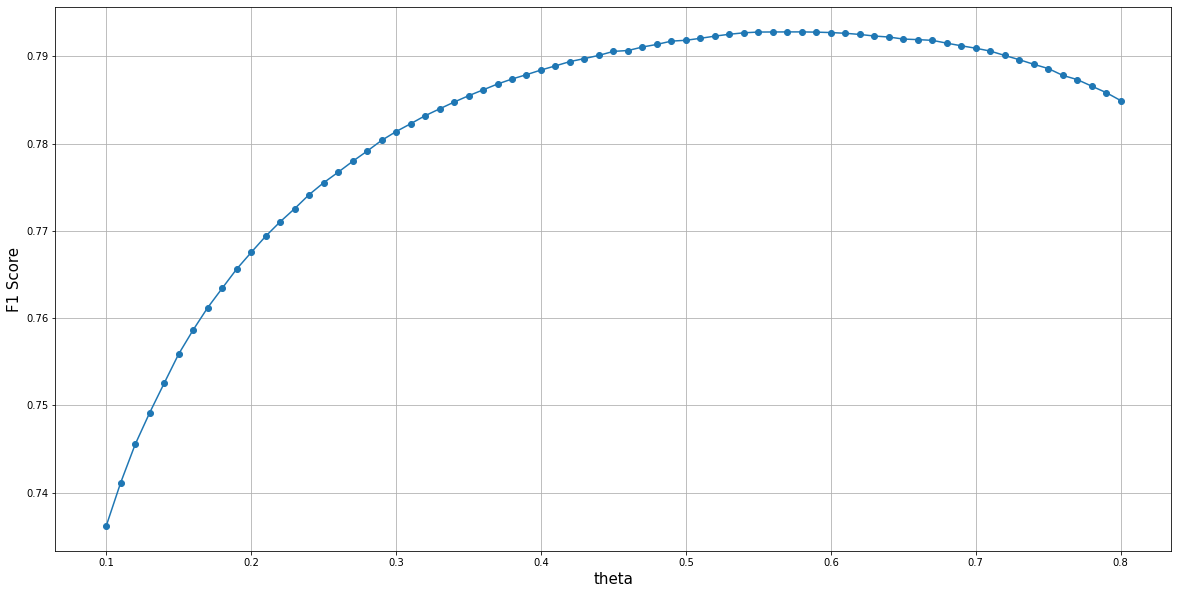

In [18]:
plt.figure(figsize=(20,10))

plt.plot(X, [lst[i][0] for i in range(len(X))], marker='o')

plt.xlabel('theta', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.grid()

plt.show()

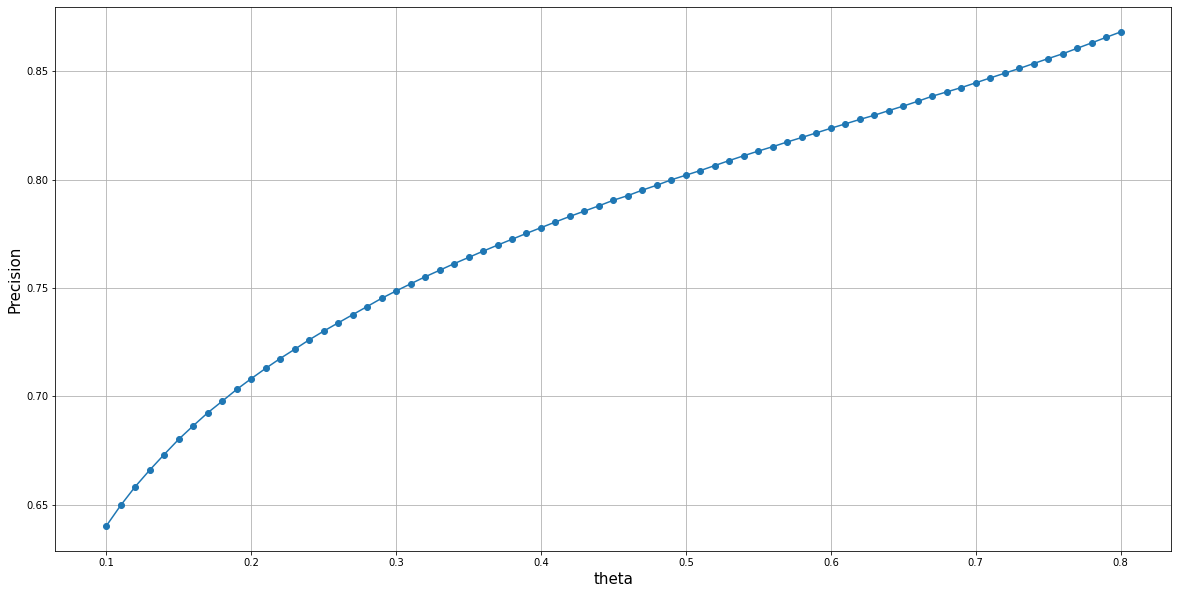

In [19]:
plt.figure(figsize=(20,10))

plt.plot(X, [lst[i][1] for i in range(len(X))], marker='o')

plt.xlabel('theta', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.grid()

plt.show()

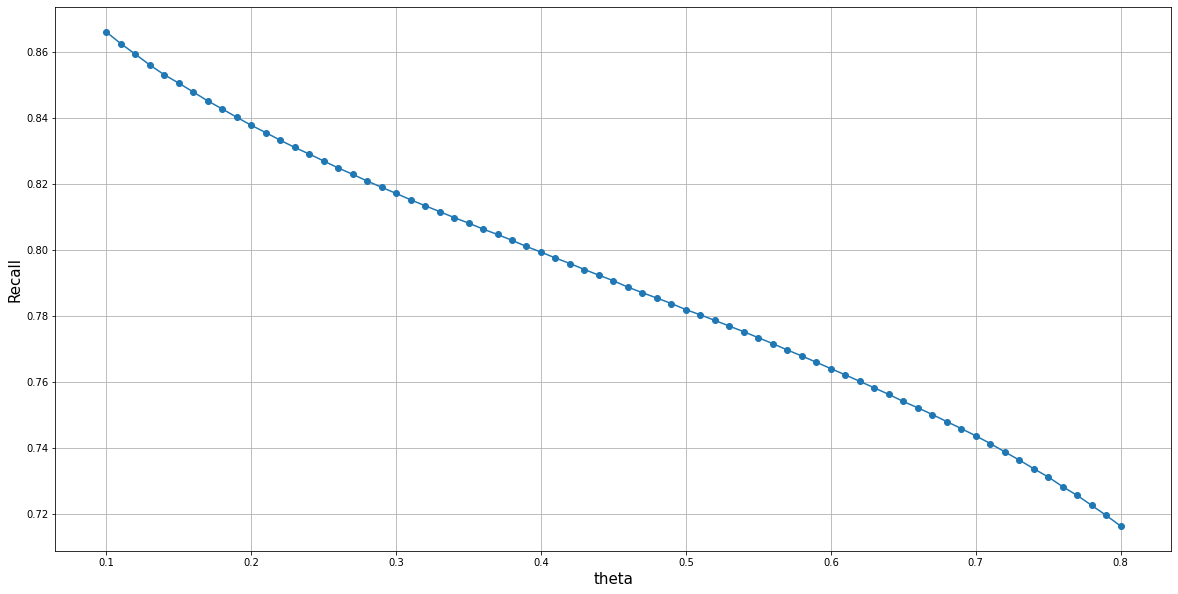

In [20]:
plt.figure(figsize=(20,10))

plt.plot(X, [lst[i][2] for i in range(len(X))], marker='o')

plt.xlabel('theta', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.grid()

plt.show()

In [21]:
theta_opti, f1_opti, precision_opti, recall_opti = 0, 0, 0, 0
for i in range (len(lst)):
  if f1_opti < lst[i][0] :
    theta_opti, f1_opti, precision_opti, recall_opti = 0.10+0.01*i, lst[i][0], lst[i][1], lst[i][2]

print('theta_opti : ', theta_opti)
print('f1_opti ; ', f1_opti)
print('precision_opti : ', precision_opti)
print('recall_opti : ', recall_opti)

theta_opti :  0.58
f1_opti ;  0.7928186699744908
precision_opti :  0.8194111984734775
recall_opti :  0.767897913240624


## Testing the Network

In [17]:
predict_on_test(debug = False, theta = theta_opti)

201406it [01:34, 2124.94it/s]
201406it [2:53:22, 19.36it/s]
